In [1]:
#import necessary libraries
import pandas as pd
import math as m
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
from torch.utils.data import DataLoader, TensorDataset

import json

# 1. High level model

In [5]:
### Initialise Training study tracking dict
# initialise whole dict (only run once per study)
eval_dict={}
dict_name='Study_High_Antoine'

# # load_evaluation dict
# dict_name='Study_0_Antoine'
# with open('trainedModels\\{}.json'.format(dict_name), 'r') as file:
#     eval_dict = json.load(file)

In [304]:
dict_name='Study_High_Antoine'
# Initialize an empty list to hold the rows
rows = []

# Initialize an empty list to hold the column headers
columns = []

# Loop through the nested dictionary to build rows and columns
for key, subdict in eval_dict.items():
    row = {}
    for subkey, subsubdict in subdict.items():
        for subsubkey, value in subsubdict.items():
            column = (subkey, subsubkey)  # subkey and subsubkey as the column header
            row[column] = value
            if column not in columns:
                columns.append(column)  # Collect all unique columns
    rows.append((key, row))

# Create a DataFrame with the columns and rows, using the key as the index
df = pd.DataFrame([row for _, row in rows], index=[key for key, _ in rows])

# Set multi-level columns (subkey, subsubkey)
df.columns = pd.MultiIndex.from_tuples(columns)

# Display the DataFrame
df.to_excel("trainedModels/high_level/{}.xlsx".format(dict_name))

## 1.1 Data import

In [305]:
data_batch='1001_1002_1003'
train_df = pd.read_csv("trainingData/1001_1002_1003_CFB_xy_train.csv")
val_df = pd.read_csv("trainingData/1001_CFB_xy_validation.csv")
test_df = pd.read_csv("trainingData/1001_CFB_xy_test.csv")

# Select features
x_names = ['L', 'b1',  't_p', 't_w', 'h_w'] # Only the ones in readily available
# Select target(s)
y_names=['eta_min_s']

x_train_df = train_df[x_names]
y_train_df = train_df[y_names]
x_val_df = val_df[x_names]
y_val_df = val_df[y_names]
x_test_df = test_df[x_names]
y_test_df = test_df[y_names]

# transfrom to numpy arrays
x_train_np = x_train_df.values
y_train_np = y_train_df.values
x_val_np = x_val_df.values
y_val_np = y_val_df.values
x_test_np = x_test_df.values
y_test_np = y_test_df.values

#Print shapes of the splitted data sets
print('Training Dataset: ',x_train_df.shape,y_train_df.shape )
print('Validation Dataset: ',x_val_df.shape, y_val_df.shape)
print('Test Dataset: ',x_test_df.shape,y_test_df.shape)



####### needed for the scaler #######
x_data_df = pd.concat([x_train_df, x_val_df, x_test_df], axis=0, ignore_index=True)
print('Total Dataset: ',x_data_df.shape )
total_data_set_size=x_data_df.shape[0]

Training Dataset:  (6390, 5) (6390, 1)
Validation Dataset:  (962, 5) (962, 1)
Test Dataset:  (1202, 5) (1202, 1)
Total Dataset:  (8554, 5)


## 1.2 Pre-process Data

### 1.2.1 Scaling data

In [138]:
#initialize scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# fit scaler on total data set
scaler.fit(x_data_df)

# scale training data
x_train_scaled_np = scaler.transform(x_train_df)
x_train_scaled_df=pd.DataFrame(data=x_train_scaled_np, columns=scaler.get_feature_names_out())

# Scale the validation data using the same scaler
x_val_scaled_np = scaler.transform(x_val_df)
x_val_scaled_df=pd.DataFrame(data=x_val_scaled_np, columns=scaler.get_feature_names_out())

# Scale the validation data using the same scaler
x_test_scaled_np = scaler.transform(x_test_df)
x_test_scaled_df=pd.DataFrame(data=x_test_scaled_np, columns=scaler.get_feature_names_out())

#plot scaled data
x_train_scaled_df.describe()

,L,b1,t_p,t_w,h_w
count,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000
mean,0.415495,0.506200,0.529696,0.516522,0.520477
std,0.211955,0.249206,0.241755,0.247641,0.231385
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.243588,0.291906,0.332464,0.314526,0.320308
50%,0.397301,0.505760,0.537985,0.521730,0.518824
75%,0.570802,0.723482,0.736202,0.728013,0.719774
max,1.000000,1.000000,1.000000,1.000000,1.000000


### 1.2.2 Convert to torch tensors

In [139]:
#training data
x_train_scaled_tensor=torch.tensor(x_train_scaled_df.values, dtype=torch.float32)
y_train_tensor=torch.tensor(y_train_df.values, dtype=torch.float32)

#validation data
x_val_scaled_tensor=torch.tensor(x_val_scaled_df.values, dtype=torch.float32)
y_val_tensor=torch.tensor(y_val_df.values, dtype=torch.float32)

#test data
x_test_scaled_tensor=torch.tensor(x_test_scaled_df.values, dtype=torch.float32)
y_test_tensor=torch.tensor(y_test_df.values, dtype=torch.float32)

## 1.3 Set up and train model

### 1.3.1 Architecture

In [287]:
layers=3
width=[5, 20, 20]
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=5, out_features=20),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=20, out_features=20),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=20, out_features=1),
    nn.ReLU()
)


#initialize error tracking lists
mse_list=[]
mse_val_list=[]

msle_list=[]
msle_val_list=[]

mean_mse_list=[]
mean_mse_val_list=[]

weighted_mse_list = []
weighted_mse_val_list = []

rmse_list=[]
rmse_val_list=[]

kl_list=[]
kl_val_list=[]

mape_list=[]
mape_val_list=[]

custom_loss_list = []
custom_loss_val_list = []

### 1.3.2 Losses

In [288]:
# get kl loss
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
# get mse loss
mse_loss = nn.MSELoss()

#import losses
from MLmodel import  weighted_mse_loss, msle_loss, mape_loss,custom_loss

### 1.3.3 Hyperparameters

In [289]:
# define kl weight for weighing of kl_loss in total loss function
kl_weight = 0.001

#get optimizer
learning_rate=0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# define epochs, and the training data, and the batch size
epochs = 500
batch_size = 32

#loss function hyperparameters for weighted mse loss
wMSE_loss_importance_range=(0.1,5)
wMSE_loss_high_weight=100

### 1.3.4 Save settings

In [290]:
#define model name:
# name rule: batch_filter_type_modeldepth_width_lossfunction_epochs_iteration
model_name='1001_1002_1003_no0_high_3_20_weighted_mse_500_5'  # define manually

# initialize model dict
eval_dict[model_name]={} 
eval_dict[model_name]['model_settings']={}
eval_dict[model_name]['training_set_performance']={}
eval_dict[model_name]['validation_set_performance']={}

# save model settings
eval_dict[model_name]['model_settings']['batch']=data_batch
eval_dict[model_name]['model_settings']['filtered']="without zero etas" # define manually
eval_dict[model_name]['model_settings']['total_data_size']=total_data_set_size
eval_dict[model_name]['model_settings']['test_split']=0.2 # define manually
eval_dict[model_name]['model_settings']['val_split']=0.2 # define manually
eval_dict[model_name]['model_settings']['layers']=layers
eval_dict[model_name]['model_settings']['width']=width

eval_dict[model_name]['model_settings']['loss']=['weighted mse'] # define manually
eval_dict[model_name]['model_settings']['wMSE_loss_importance_range']=wMSE_loss_importance_range
eval_dict[model_name]['model_settings']['wMSE_loss_high_weight']=wMSE_loss_high_weight

eval_dict[model_name]['model_settings']['kl_weight']=kl_weight
eval_dict[model_name]['model_settings']['learning_rate']=[0.001]#learning_rate
eval_dict[model_name]['model_settings']['epochs']=[500]#epochs
eval_dict[model_name]['model_settings']['batch_size']=batch_size
# eval_dict

### 1.3.5 Training loop

In [291]:
# Shuffle is set to True to randomize the order of training data at each epoch
train_dataset = TensorDataset(x_train_scaled_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# x = x_train_scaled_tensor
# y = y_train_transf_tensor
with_stochasticPrediction=False

#training loop
for step in range(epochs):
    
    model.train()

    epoch_mse = []
    epoch_msle = []
    epoch_weighted_mse = []
    epoch_rmse = []
    epoch_kl = []
    epoch_mape = []
    epoch_custom = []

    for x, y in train_loader:
        y_pred = model(x)

        if with_stochasticPrediction:
            y_pred_mean_np, y_pred_std_np, y_pred_n_times=bnn_predict_with_uncertainty(model, x, n=100)
            y_pred_mean_tensor=torch.tensor(y_pred_mean_np, dtype=torch.float32)
            mean_mse = mse_loss(y_pred_mean_tensor, y)
            mean_mse_list.append(mean_mse.item())
            
        #standard mse, rmse loss
        mse = mse_loss(y_pred, y)
        epoch_mse.append(mse.item())
        # mse_list.append(mse.item())
        rmse = torch.sqrt(mse)
        epoch_rmse.append(rmse.item())

        #msle loss
        msle = msle_loss(y_pred, y,base='10')
        epoch_msle.append(msle.item())
        # msle_list.append(msle.item())

        # weighted MSE loss
        weighted_mse = weighted_mse_loss(y_pred, y, importance_range=wMSE_loss_importance_range, high_weight=wMSE_loss_high_weight)
        epoch_weighted_mse.append(weighted_mse.item())
        # custom_mse_list.append(custom_mse.item())

        # mape
        mape= mape_loss(y_pred, y)
        epoch_mape.append(mape.item())


        # # Custom loss
        custom = custom_loss(y_pred, y, threshold=0.5, alpha=1, beta=1)
        epoch_custom.append(custom.item())

        #kl_divergence loss
        kl = kl_loss(model)
        epoch_kl.append(kl.item())
        # kl_list.append(kl.item())

        # Add individual losses weighted to single loss
        cost = rmse + kl_weight*kl
        cost_log=msle + kl_weight*kl
        cost_weighted_mse= weighted_mse + kl_weight*kl
        cost_mape = mape + kl_weight*kl
        cost_custom=custom + kl_weight*kl
        
        optimizer.zero_grad()
        cost_weighted_mse.backward() #Specify loss that should be used here
        optimizer.step()

    # Calculate mean losses for the epoch (on training data) and save in loss lists
    mse_list.append(np.mean(epoch_mse))
    rmse_list.append(np.mean(epoch_rmse))
    msle_list.append(np.mean(epoch_msle))
    weighted_mse_list.append(np.mean(epoch_weighted_mse))
    kl_list.append(np.mean(epoch_kl))
    mape_list.append(np.mean(epoch_mape))
    custom_loss_list.append(np.mean(epoch_custom))

    # Calculate validation loss calculation and save in loss tracking lists
    model.eval()
    with torch.no_grad():
        y_val_pred = model(x_val_scaled_tensor)

        #standard mse, rmse loss
        mse_val = mse_loss(y_val_pred, y_val_tensor)
        mse_val_list.append(mse_val.item())
        rmse_val = torch.sqrt(mse_val)
        rmse_val_list.append(rmse_val.item())

        #msle los
        msle_val = msle_loss(y_val_pred, y_val_tensor, base='10')
        msle_val_list.append(msle_val.item())

        # weighted MSE loss
        weighted_mse_val = weighted_mse_loss(y_val_pred, y_val_tensor, importance_range=(0, 4), high_weight=10)
        weighted_mse_val_list.append(weighted_mse_val.item())

        # mape loss
        mape_val = mape_loss(y_val_pred, y_val_tensor)
        mape_val_list.append(mape_val.item())

        # custom loss
        custom_val = custom_loss(y_val_pred, y_val_tensor, threshold=0.5, alpha=1, beta=1)
        custom_loss_val_list.append(custom_val.item())
        

            

    # verbalise
    if step % 50 == 0:
        if with_stochasticPrediction:
            print(f'Step {step}, On Training Set: MSE: {mse.item():.2f}, Mean MSE: {mean_mse.item():.2f}, MSLE: {msle.item():.2f}, KL: {kl.item():.2f}, RMSE: {rmse.item():.2f}, '
                f'Weighted MSE: {weighted_mse.item():.2f}, MAPE: {mape.item():.2f}, Custom Loss: {custom.item():.2f}; '
                'On Validation Set:', f'Val MSE: {mse_val.item():.2f}, Val MSLE: {msle_val.item():.2f}, Val RMSE: {rmse_val.item():.2f}, Val Weighted MSE: {weighted_mse_val.item():.2f}, '
                f'Val MAPE: {mape_val.item():.2f}, Val Custom Loss: {custom_val.item():.2f}')
        else: 
            print(f'Step {step}, On Training Set: MSE: {mse.item():.2f}, MSLE: {msle.item():.2f}, KL: {kl.item():.2f}, RMSE: {rmse.item():.2f}, '
                f'Weighted MSE: {weighted_mse.item():.2f}, MAPE: {mape.item():.2f}, Custom Loss: {custom.item():.2f}; '
                'On Validation Set:', f'Val MSE: {mse_val.item():.2f}, Val MSLE: {msle_val.item():.2f}, Val RMSE: {rmse_val.item():.2f}, Val Weighted MSE: {weighted_mse_val.item():.2f}, '
                f'Val MAPE: {mape_val.item():.2f}, Val Custom Loss: {custom_val.item():.2f}')

    

    


print('Training is finished. The final losses:') 
if with_stochasticPrediction:
    print(f'Step {step}, On Training Set: MSE: {mse.item():.2f}, Mean MSE: {mean_mse.item():.2f}, MSLE: {msle.item():.2f}, KL: {kl.item():.2f}, RMSE: {rmse.item():.2f}, '
          f'Weighted MSE: {weighted_mse.item():.2f}, MAPE: {mape.item():.2f}, Custom Loss: {custom.item():.2f}, '
          'On Validation Set:', f'Val MSE: {mse_val.item():.2f}, Val MSLE: {msle_val.item():.2f}, Val RMSE: {rmse_val.item():.2f}, Val Weighted MSE: {weighted_mse_val.item():.2f}, '
          f'Val MAPE: {mape_val.item():.2f}, Val Custom Loss: {custom_val.item():.2f}')
else:
    print(f'Step {step}, On Training Set: MSE: {mse.item():.2f}, MSLE: {msle.item():.2f}, KL: {kl.item():.2f}, RMSE: {rmse.item():.2f}, '
          f'Weighted MSE: {weighted_mse.item():.2f}, MAPE: {mape.item():.2f}, Custom Loss: {custom.item():.2f}, '
          'On Validation Set:', f'Val MSE: {mse_val.item():.2f}, Val MSLE: {msle_val.item():.2f}, Val RMSE: {rmse_val.item():.2f}, Val Weighted MSE: {weighted_mse_val.item():.2f}, '
          f'Val MAPE: {mape_val.item():.2f}, Val Custom Loss: {custom_val.item():.2f}')

Step 0, On Training Set: MSE: 9.29, MSLE: 0.04, KL: 1.45, RMSE: 3.05, Weighted MSE: 23.45, MAPE: 21.03, Custom Loss: 0.21; On Validation Set: Val MSE: 62.60, Val MSLE: 0.10, Val RMSE: 7.91, Val Weighted MSE: 66.87, Val MAPE: 49.76, Val Custom Loss: 0.50
Step 50, On Training Set: MSE: 24.92, MSLE: 0.02, KL: 5.47, RMSE: 4.99, Weighted MSE: 40.27, MAPE: 18.06, Custom Loss: 0.18; On Validation Set: Val MSE: 52.97, Val MSLE: 0.05, Val RMSE: 7.28, Val Weighted MSE: 55.47, Val MAPE: 30.62, Val Custom Loss: 0.31
Step 100, On Training Set: MSE: 5.19, MSLE: 0.03, KL: 12.59, RMSE: 2.28, Weighted MSE: 74.85, MAPE: 32.72, Custom Loss: 0.33; On Validation Set: Val MSE: 40.65, Val MSLE: 0.03, Val RMSE: 6.38, Val Weighted MSE: 43.36, Val MAPE: 31.97, Val Custom Loss: 0.32
Step 150, On Training Set: MSE: 0.66, MSLE: 0.01, KL: 20.34, RMSE: 0.81, Weighted MSE: 7.82, MAPE: 17.03, Custom Loss: 0.17; On Validation Set: Val MSE: 32.47, Val MSLE: 0.02, Val RMSE: 5.70, Val Weighted MSE: 34.93, Val MAPE: 28.77,

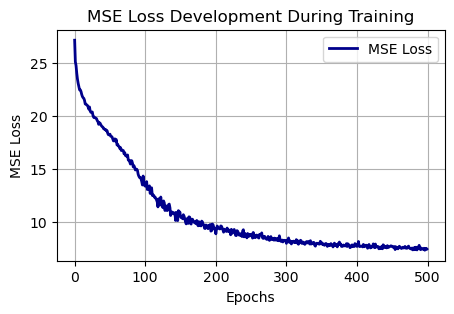

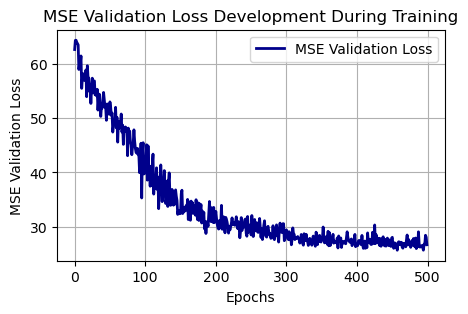

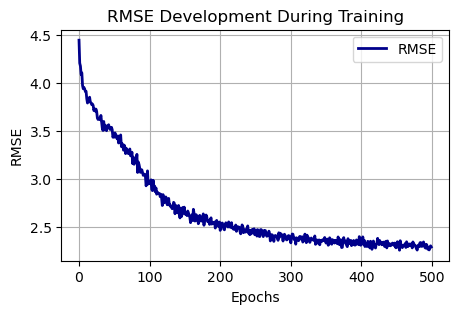

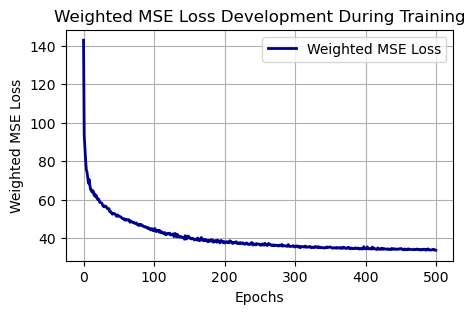

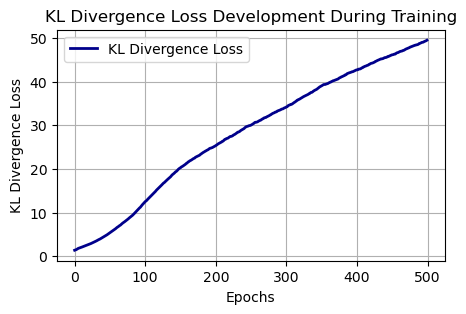

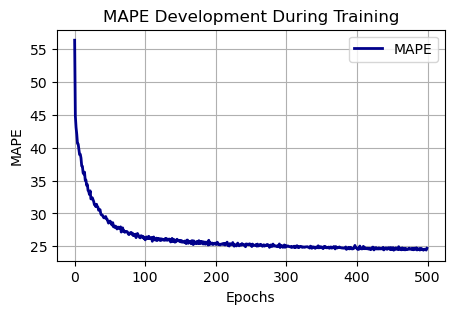

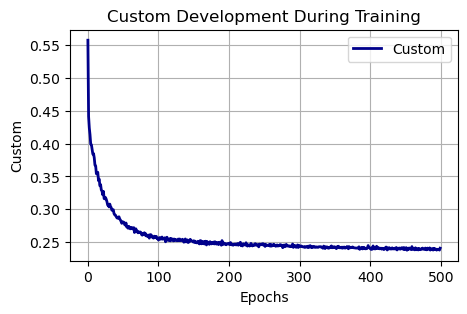

In [292]:
from plotting import plot_loss_development

loss_lists = [mse_list, mse_val_list, rmse_list, weighted_mse_list, kl_list, mape_list, custom_loss_list]
# loss_lists = [mse_list, mean_mse_list, kl_list, rmse_list, weighted_mse_list]
loss_names = ['MSE Loss', 'MSE Validation Loss', 'RMSE', 'Weighted MSE Loss', 'KL Divergence Loss', 'MAPE', 'Custom']
# loss_names = ['MSE Loss', 'Mean MSE Loss', 'KL Divergence Loss', 'RMSE', 'Custom MSE Loss']

# Define a path to save the plots, if needed
save_path = 'trainedModels' # Example path, change it as needed

plot_loss_development(loss_lists, loss_names, save_path, color='darkblue', model_name=model_name, figsize=(5, 3))

### 1.3.6 Save Model

In [293]:
#saving the whole model
torch.save(model, 'trainedModels/high_level/'+model_name+'.pth')

#saving just the weights and biases
#torch.save(model.state_dict(), 'trainedModels\\'+name_training_run+'.pth')

## 1.4 Model evaluation

### 1.4.1 Load model

In [294]:
# model_name='1001_1002_1003_no0_high_3_40_weighted_mse_100_0'
model = torch.load('trainedModels/high_level/'+model_name+'.pth')

model.eval() # sets the model to evaluation mode, which affects layers like dropout and batch normalization that behave differently during training and inference.
model

C:\Users\Antoine\AppData\Local\Temp\ipykernel_32952\2577255704.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('trainedModels/high_level/'+model_name+

Sequential(
  (0): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=5, out_features=20, bias=True)
  (1): ReLU()
  (2): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=20, out_features=20, bias=True)
  (3): ReLU()
  (4): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=20, out_features=1, bias=True)
  (5): ReLU()
)

In [295]:
from plotting import plot_true_vs_pred, single_para_strudy_perf
from MLmodel import bnn_predict_with_uncertainty, calculate_rmse, filter_values_within_range, calculate_mape, calculate_custom_loss, evaluate_model_performance

### 1.4.2 Evaluation of training data

#### 1.4.2.1 Make predicitons and calculate mean

In [296]:
# Define number of predictions
n_predictions = 1000
# Perfrom multiple predictions on data --> get mean and std for each data point
y_train_mean_pred_np, y_train_std_pred_np, y_train_pred_n_times = bnn_predict_with_uncertainty(model, x_train_scaled_tensor, n=n_predictions, log_transform_back=False)

#### 1.4.2.2 Uncertainty evaluation

In [297]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define a range of confidence levels
confidence_levels = np.linspace(0, 1, 100)
coverages = []

# Compute prediction intervals (e.g., 95% confidence intervals) (Assumption that the predictive distribution is a normal dirtsibution)
for confidence_level in confidence_levels:
    z = norm.ppf((1 + confidence_level) / 2)  # z-score for the confidence level
    prediction_intervals = np.array([
        [meanPred - z * std, meanPred + z * std]
        for meanPred, std in zip(y_train_mean_pred_np, y_train_std_pred_np)
    ])

    # Check if actual values fall within prediction intervals
    within_intervals = np.array([
        interval[0] <= y_true <= interval[1]
        for interval, y_true in zip(prediction_intervals, y_train_np)
    ])
    
    # Proportion of times actual values fall within prediction intervals
    coverage = np.mean(within_intervals)
    coverages.append(coverage)

#print(coverages)

from sklearn.metrics import mean_squared_error
# Calculate Expected Calibration Error (ECE)
ece = np.mean(np.abs(confidence_levels - coverages))
#print("Expected Calibration Error (ECE):", ece)

# Calculate Total Calibration Error (TCE)
tce = np.sum(np.abs(confidence_levels - coverages))
# print("Total Calibration Error (TCE):", tce)

# Calculate Bias (Positive for Overconfidence, Negative for Underconfidence)
bias = np.sum(confidence_levels - coverages)

#### 1.4.2.3 Save to dict

In [298]:
sub_dict_name='training_set_performance'

# save to dict
eval_dict=evaluate_model_performance(y_true=y_train_np, y_pred=y_train_mean_pred_np,
                                      dict_name=sub_dict_name, model_name=model_name, eval_dict=eval_dict)
eval_dict[model_name][sub_dict_name]['ECE']=ece
eval_dict[model_name][sub_dict_name]['TCE']=tce
eval_dict[model_name][sub_dict_name]['CB']=bias

#### 1.4.3 Evaluation of validation data

#### 1.4.3.1 Make predicitons and calculate mean

In [299]:
# Define number of predictions
n_predictions = 1000

# Perfrom multiple predictions on data --> get mean and std for each data point
y_val_mean_pred_np, y_val_std_pred_np, y_val_pred_n_times = bnn_predict_with_uncertainty(model, x_val_scaled_tensor, n=n_predictions,log_transform_back=False)

#### 1.4.3.2 Uncertainty evaluation

In [300]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


# Define a range of confidence levels
confidence_levels = np.linspace(0, 1, 100)
coverages = []

# Compute prediction intervals (e.g., 95% confidence intervals) (Assumption that the predictive distribution is a normal dirtsibution)
for confidence_level in confidence_levels:
    z = norm.ppf((1 + confidence_level) / 2)  # z-score for the confidence level
    prediction_intervals = np.array([
        [meanPred - z * std, meanPred + z * std]
        for meanPred, std in zip(y_val_mean_pred_np, y_val_std_pred_np)
    ])

    # Check if actual values fall within prediction intervals
    within_intervals = np.array([
        interval[0] <= y_true <= interval[1]
        for interval, y_true in zip(prediction_intervals, y_val_np)
    ])
    
    # Proportion of times actual values fall within prediction intervals
    coverage = np.mean(within_intervals)
    coverages.append(coverage)

# print(coverages)


# Calculate Expected Calibration Error (ECE)
ece = np.mean(np.abs(confidence_levels - coverages))
# print("Expected Calibration Error (ECE):", ece)

# Calculate Total Calibration Error (TCE)
tce = np.sum(np.abs(confidence_levels - coverages))
# print("Total Calibration Error (TCE):", tce)

# Calculate Bias (Positive for Overconfidence, Negative for Underconfidence)
bias = np.sum(confidence_levels - coverages)
# print("Calibration Bias:", bias)

#### 1.4.3.3 Save to dict

In [301]:
sub_dict_name='validation_set_performance'

#save to dict
eval_dict=evaluate_model_performance(y_true=y_val_np, y_pred=y_val_mean_pred_np,
                                      dict_name=sub_dict_name, model_name=model_name, eval_dict=eval_dict)
eval_dict[model_name][sub_dict_name]['ECE']=ece
eval_dict[model_name][sub_dict_name]['TCE']=tce
eval_dict[model_name][sub_dict_name]['CB']=bias

## 1.5 Save dict

In [303]:
#naming
dict_name='Study_High_Antoine'
# Saving the dictionary to a JSON file
with open('trainedModels/high_level/{}.json'.format(dict_name), 'w') as file:
    json.dump(eval_dict, file, indent=4)

# 2. Feature importance

## 2.1 Data import

In [2]:
data_batch='1001_1002_1003'
train_df = pd.read_csv("trainingData/1001_1002_1003_CFB_xy_train.csv")
val_df = pd.read_csv("trainingData/1001_CFB_xy_validation.csv")
test_df = pd.read_csv("trainingData/1001_CFB_xy_test.csv")

# Select features
x_names = ['L', 'b1',  't_p', 't_w', 'h_w', 'd1_plate', 'd4_plate', 'd2_plate', 's_plate', 'd1_walls', 'd4_walls', 's_walls', 'fcc', 's', 'beta', 'h_G'] # all 16 features
# Select target(s)
y_names=['eta_min_s']

x_train_df = train_df[x_names]
y_train_df = train_df[y_names]
x_val_df = val_df[x_names]
y_val_df = val_df[y_names]
x_test_df = test_df[x_names]
y_test_df = test_df[y_names]

# transfrom to numpy arrays
x_train_np = x_train_df.values
y_train_np = y_train_df.values
x_val_np = x_val_df.values
y_val_np = y_val_df.values
x_test_np = x_test_df.values
y_test_np = y_test_df.values

#Print shapes of the splitted data sets
print('Training Dataset: ',x_train_df.shape,y_train_df.shape )
print('Validation Dataset: ',x_val_df.shape, y_val_df.shape)
print('Test Dataset: ',x_test_df.shape,y_test_df.shape)



####### needed for the scaler #######
x_data_df = pd.concat([x_train_df, x_val_df, x_test_df], axis=0, ignore_index=True)
print('Total Dataset: ',x_data_df.shape )
total_data_set_size=x_data_df.shape[0]

Training Dataset:  (6390, 16) (6390, 1)
Validation Dataset:  (962, 16) (962, 1)
Test Dataset:  (1202, 16) (1202, 1)
Total Dataset:  (8554, 16)


## 2.2 Pre-process Data

### 2.2.1 Scaling data

In [3]:
#initialize scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# fit scaler on total data set
scaler.fit(x_data_df)

# scale training data
x_train_scaled_np = scaler.transform(x_train_df)
x_train_scaled_df=pd.DataFrame(data=x_train_scaled_np, columns=scaler.get_feature_names_out())

# Scale the validation data using the same scaler
x_val_scaled_np = scaler.transform(x_val_df)
x_val_scaled_df=pd.DataFrame(data=x_val_scaled_np, columns=scaler.get_feature_names_out())

# Scale the validation data using the same scaler
x_test_scaled_np = scaler.transform(x_test_df)
x_test_scaled_df=pd.DataFrame(data=x_test_scaled_np, columns=scaler.get_feature_names_out())

#plot scaled data
x_train_scaled_df.describe()

,L,b1,t_p,t_w,h_w,d1_plate,d4_plate,d2_plate,s_plate,d1_walls,d4_walls,s_walls,fcc,s,beta,h_G
count,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000
mean,0.415495,0.506200,0.529696,0.516522,0.520477,0.538362,0.523458,0.495844,0.488939,0.499127,0.505126,0.502811,0.502508,0.484397,0.506549,0.492128
std,0.211955,0.249206,0.241755,0.247641,0.231385,0.246179,0.246705,0.257305,0.241203,0.240128,0.247971,0.243358,0.243815,0.248703,0.253079,0.240827
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.243588,0.291906,0.332464,0.314526,0.320308,0.336437,0.317310,0.273541,0.281327,0.295519,0.293597,0.294216,0.293180,0.269763,0.287704,0.284334
50%,0.397301,0.505760,0.537985,0.521730,0.518824,0.554046,0.534811,0.496987,0.474742,0.501949,0.511408,0.494456,0.498634,0.482650,0.502191,0.493189
75%,0.570802,0.723482,0.736202,0.728013,0.719774,0.752311,0.735745,0.722166,0.691609,0.707330,0.717054,0.708527,0.710452,0.701978,0.727111,0.693674
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 2.2.2 Convert to torch tensors

In [4]:
#training data
x_train_scaled_tensor=torch.tensor(x_train_scaled_df.values, dtype=torch.float32)
y_train_tensor=torch.tensor(y_train_df.values, dtype=torch.float32)

#validation data
x_val_scaled_tensor=torch.tensor(x_val_scaled_df.values, dtype=torch.float32)
y_val_tensor=torch.tensor(y_val_df.values, dtype=torch.float32)

#test data
x_test_scaled_tensor=torch.tensor(x_test_scaled_df.values, dtype=torch.float32)
y_test_tensor=torch.tensor(y_test_df.values, dtype=torch.float32)

## 2.3 Set up and train model

### 2.3.1 Architecture

In [309]:
layers=1
width=[16]
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=16, out_features=1),
    nn.ReLU(),
)


#initialize error tracking lists
mse_list=[]
mse_val_list=[]

msle_list=[]
msle_val_list=[]

mean_mse_list=[]
mean_mse_val_list=[]

weighted_mse_list = []
weighted_mse_val_list = []

rmse_list=[]
rmse_val_list=[]

kl_list=[]
kl_val_list=[]

mape_list=[]
mape_val_list=[]

custom_loss_list = []
custom_loss_val_list = []

### 2.3.2 Losses

In [310]:
# get kl loss
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
# get mse loss
mse_loss = nn.MSELoss()

#import losses
from MLmodel import  weighted_mse_loss, msle_loss, mape_loss,custom_loss

### 2.3.3 Hyperparameters

In [311]:
# define kl weight for weighing of kl_loss in total loss function
kl_weight = 0.001

#get optimizer
learning_rate=0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# define epochs, and the training data, and the batch size
epochs = 500
batch_size = 32

#loss function hyperparameters for weighted mse loss
wMSE_loss_importance_range=(0.1,5)
wMSE_loss_high_weight=100

### 2.3.5 Training loop

In [312]:
# Shuffle is set to True to randomize the order of training data at each epoch
train_dataset = TensorDataset(x_train_scaled_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# x = x_train_scaled_tensor
# y = y_train_transf_tensor
with_stochasticPrediction=False

#training loop
for step in range(epochs):
    
    model.train()

    epoch_mse = []
    epoch_msle = []
    epoch_weighted_mse = []
    epoch_rmse = []
    epoch_kl = []
    epoch_mape = []
    epoch_custom = []

    for x, y in train_loader:
        y_pred = model(x)

        if with_stochasticPrediction:
            y_pred_mean_np, y_pred_std_np, y_pred_n_times=bnn_predict_with_uncertainty(model, x, n=100)
            y_pred_mean_tensor=torch.tensor(y_pred_mean_np, dtype=torch.float32)
            mean_mse = mse_loss(y_pred_mean_tensor, y)
            mean_mse_list.append(mean_mse.item())
            
        #standard mse, rmse loss
        mse = mse_loss(y_pred, y)
        epoch_mse.append(mse.item())
        # mse_list.append(mse.item())
        rmse = torch.sqrt(mse)
        epoch_rmse.append(rmse.item())

        #msle loss
        msle = msle_loss(y_pred, y,base='10')
        epoch_msle.append(msle.item())
        # msle_list.append(msle.item())

        # weighted MSE loss
        weighted_mse = weighted_mse_loss(y_pred, y, importance_range=wMSE_loss_importance_range, high_weight=wMSE_loss_high_weight)
        epoch_weighted_mse.append(weighted_mse.item())
        # custom_mse_list.append(custom_mse.item())

        # mape
        mape= mape_loss(y_pred, y)
        epoch_mape.append(mape.item())


        # # Custom loss
        custom = custom_loss(y_pred, y, threshold=0.5, alpha=1, beta=1)
        epoch_custom.append(custom.item())

        #kl_divergence loss
        kl = kl_loss(model)
        epoch_kl.append(kl.item())
        # kl_list.append(kl.item())

        # Add individual losses weighted to single loss
        cost = rmse + kl_weight*kl
        cost_log=msle + kl_weight*kl
        cost_weighted_mse= weighted_mse + kl_weight*kl
        cost_mape = mape + kl_weight*kl
        cost_custom=custom + kl_weight*kl
        
        optimizer.zero_grad()
        cost_weighted_mse.backward() #Specify loss that should be used here
        optimizer.step()

    # Calculate mean losses for the epoch (on training data) and save in loss lists
    mse_list.append(np.mean(epoch_mse))
    rmse_list.append(np.mean(epoch_rmse))
    msle_list.append(np.mean(epoch_msle))
    weighted_mse_list.append(np.mean(epoch_weighted_mse))
    kl_list.append(np.mean(epoch_kl))
    mape_list.append(np.mean(epoch_mape))
    custom_loss_list.append(np.mean(epoch_custom))

    # Calculate validation loss calculation and save in loss tracking lists
    model.eval()
    with torch.no_grad():
        y_val_pred = model(x_val_scaled_tensor)

        #standard mse, rmse loss
        mse_val = mse_loss(y_val_pred, y_val_tensor)
        mse_val_list.append(mse_val.item())
        rmse_val = torch.sqrt(mse_val)
        rmse_val_list.append(rmse_val.item())

        #msle los
        msle_val = msle_loss(y_val_pred, y_val_tensor, base='10')
        msle_val_list.append(msle_val.item())

        # weighted MSE loss
        weighted_mse_val = weighted_mse_loss(y_val_pred, y_val_tensor, importance_range=(0, 4), high_weight=10)
        weighted_mse_val_list.append(weighted_mse_val.item())

        # mape loss
        mape_val = mape_loss(y_val_pred, y_val_tensor)
        mape_val_list.append(mape_val.item())

        # custom loss
        custom_val = custom_loss(y_val_pred, y_val_tensor, threshold=0.5, alpha=1, beta=1)
        custom_loss_val_list.append(custom_val.item())
        

            

    # verbalise
    if step % 50 == 0:
        if with_stochasticPrediction:
            print(f'Step {step}, On Training Set: MSE: {mse.item():.2f}, Mean MSE: {mean_mse.item():.2f}, MSLE: {msle.item():.2f}, KL: {kl.item():.2f}, RMSE: {rmse.item():.2f}, '
                f'Weighted MSE: {weighted_mse.item():.2f}, MAPE: {mape.item():.2f}, Custom Loss: {custom.item():.2f}; '
                'On Validation Set:', f'Val MSE: {mse_val.item():.2f}, Val MSLE: {msle_val.item():.2f}, Val RMSE: {rmse_val.item():.2f}, Val Weighted MSE: {weighted_mse_val.item():.2f}, '
                f'Val MAPE: {mape_val.item():.2f}, Val Custom Loss: {custom_val.item():.2f}')
        else: 
            print(f'Step {step}, On Training Set: MSE: {mse.item():.2f}, MSLE: {msle.item():.2f}, KL: {kl.item():.2f}, RMSE: {rmse.item():.2f}, '
                f'Weighted MSE: {weighted_mse.item():.2f}, MAPE: {mape.item():.2f}, Custom Loss: {custom.item():.2f}; '
                'On Validation Set:', f'Val MSE: {mse_val.item():.2f}, Val MSLE: {msle_val.item():.2f}, Val RMSE: {rmse_val.item():.2f}, Val Weighted MSE: {weighted_mse_val.item():.2f}, '
                f'Val MAPE: {mape_val.item():.2f}, Val Custom Loss: {custom_val.item():.2f}')

    

    


print('Training is finished. The final losses:') 
if with_stochasticPrediction:
    print(f'Step {step}, On Training Set: MSE: {mse.item():.2f}, Mean MSE: {mean_mse.item():.2f}, MSLE: {msle.item():.2f}, KL: {kl.item():.2f}, RMSE: {rmse.item():.2f}, '
          f'Weighted MSE: {weighted_mse.item():.2f}, MAPE: {mape.item():.2f}, Custom Loss: {custom.item():.2f}, '
          'On Validation Set:', f'Val MSE: {mse_val.item():.2f}, Val MSLE: {msle_val.item():.2f}, Val RMSE: {rmse_val.item():.2f}, Val Weighted MSE: {weighted_mse_val.item():.2f}, '
          f'Val MAPE: {mape_val.item():.2f}, Val Custom Loss: {custom_val.item():.2f}')
else:
    print(f'Step {step}, On Training Set: MSE: {mse.item():.2f}, MSLE: {msle.item():.2f}, KL: {kl.item():.2f}, RMSE: {rmse.item():.2f}, '
          f'Weighted MSE: {weighted_mse.item():.2f}, MAPE: {mape.item():.2f}, Custom Loss: {custom.item():.2f}, '
          'On Validation Set:', f'Val MSE: {mse_val.item():.2f}, Val MSLE: {msle_val.item():.2f}, Val RMSE: {rmse_val.item():.2f}, Val Weighted MSE: {weighted_mse_val.item():.2f}, '
          f'Val MAPE: {mape_val.item():.2f}, Val Custom Loss: {custom_val.item():.2f}')

Step 0, On Training Set: MSE: 1.62, MSLE: 0.03, KL: 1.57, RMSE: 1.27, Weighted MSE: 76.81, MAPE: 27.32, Custom Loss: 0.27; On Validation Set: Val MSE: 62.94, Val MSLE: 0.10, Val RMSE: 7.93, Val Weighted MSE: 67.30, Val MAPE: 47.44, Val Custom Loss: 0.47
Step 50, On Training Set: MSE: 4.63, MSLE: 0.03, KL: 43.77, RMSE: 2.15, Weighted MSE: 17.25, MAPE: 31.01, Custom Loss: 0.31; On Validation Set: Val MSE: 57.59, Val MSLE: 0.06, Val RMSE: 7.59, Val Weighted MSE: 59.80, Val MAPE: 36.61, Val Custom Loss: 0.37
Step 100, On Training Set: MSE: 0.43, MSLE: 0.01, KL: 61.43, RMSE: 0.66, Weighted MSE: 21.64, MAPE: 31.61, Custom Loss: 0.32; On Validation Set: Val MSE: 56.52, Val MSLE: 0.06, Val RMSE: 7.52, Val Weighted MSE: 58.76, Val MAPE: 37.93, Val Custom Loss: 0.38
Step 150, On Training Set: MSE: 23.36, MSLE: 0.04, KL: 63.75, RMSE: 4.83, Weighted MSE: 41.88, MAPE: 34.43, Custom Loss: 0.34; On Validation Set: Val MSE: 56.63, Val MSLE: 0.06, Val RMSE: 7.53, Val Weighted MSE: 58.82, Val MAPE: 37.3

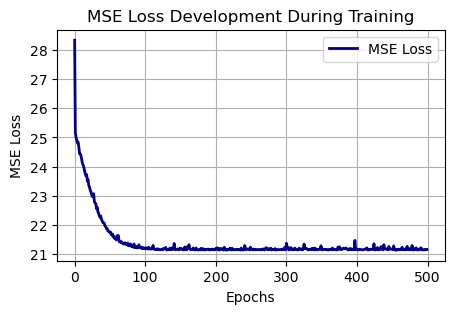

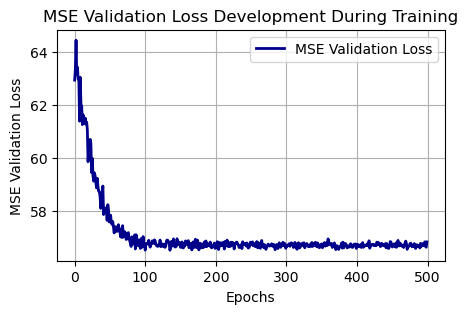

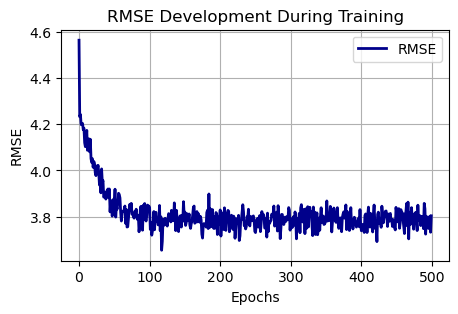

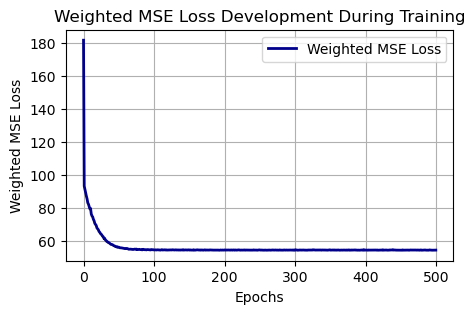

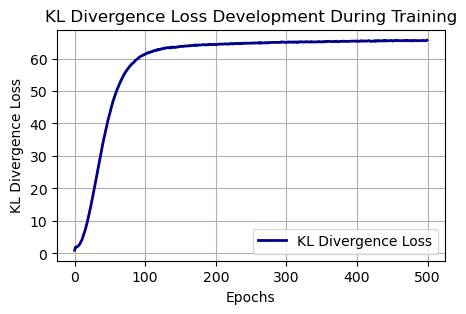

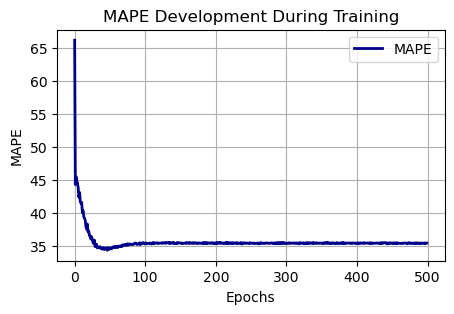

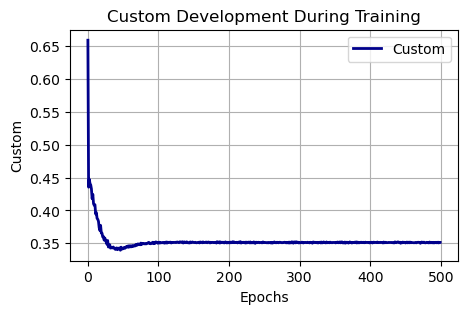

In [313]:
from plotting import plot_loss_development

loss_lists = [mse_list, mse_val_list, rmse_list, weighted_mse_list, kl_list, mape_list, custom_loss_list]
# loss_lists = [mse_list, mean_mse_list, kl_list, rmse_list, weighted_mse_list]
loss_names = ['MSE Loss', 'MSE Validation Loss', 'RMSE', 'Weighted MSE Loss', 'KL Divergence Loss', 'MAPE', 'Custom']
# loss_names = ['MSE Loss', 'Mean MSE Loss', 'KL Divergence Loss', 'RMSE', 'Custom MSE Loss']

# Define a path to save the plots, if needed
save_path = 'trainedModels/detail_level' # Example path, change it as needed

plot_loss_development(loss_lists, loss_names, save_path, color='darkblue', model_name=model_name, figsize=(5, 3))

### 2.3.6 Save Model

In [314]:
#saving the whole model
model_name='1001_1002_1003_no0_detail_1_16_weighted_mse_500_5'  # define manually
torch.save(model, 'trainedModels/detail_level/'+model_name+'.pth')

#saving just the weights and biases
#torch.save(model.state_dict(), 'trainedModels\\'+name_training_run+'.pth')

## 2.4 Model evaluation - Single layer model

### 2.4.1 Load model

In [5]:
# model_name='1001_1002_1003_no0_high_3_40_weighted_mse_100_0'
model_name='1001_1002_1003_no0_detail_1_16_weighted_mse_500_5'  # define manually
model = torch.load('trainedModels/detail_level/'+model_name+'.pth')

model.eval() # sets the model to evaluation mode, which affects layers like dropout and batch normalization that behave differently during training and inference.
model

C:\Users\Antoine\AppData\Local\Temp\ipykernel_41020\2150103138.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('trainedModels/detail_level/'+model_nam

Sequential(
  (0): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=16, out_features=1, bias=True)
  (1): ReLU()
)

### 2.4.2 Feature importance

In [321]:
l = model.state_dict()

OrderedDict([('0.weight_mu',
              tensor([[-3.6194,  0.1299,  1.4957,  1.2044, -0.3523,  0.6168,  0.7102, -0.0828,
                       -0.9332,  0.2014,  0.3281, -0.3479,  0.0378,  0.0474,  0.0114, -0.0684]])),
             ('0.weight_log_sigma',
              tensor([[-6.3542, -5.9777, -5.8843, -6.0221, -6.2599, -5.9317, -6.2039, -5.8866,
                       -6.1206, -6.1307, -6.2439, -5.9721, -5.8694, -5.7198, -6.2978, -6.1873]])),
             ('0.bias_mu', tensor([1.4833])),
             ('0.bias_log_sigma', tensor([-6.2729]))])

In [327]:
# Fetch the importances from model.coef_
for i in range(16):
  print(f"{x_names[i]:<8}  "
  f"mu: {abs(l['0.weight_mu'][0][i]):.3f}, log_sigma: {abs(l["0.weight_log_sigma"][0][i]):.3f}")

L         mu: 3.619, log_sigma: 6.354
b1        mu: 0.130, log_sigma: 5.978
t_p       mu: 1.496, log_sigma: 5.884
t_w       mu: 1.204, log_sigma: 6.022
h_w       mu: 0.352, log_sigma: 6.260
d1_plate  mu: 0.617, log_sigma: 5.932
d4_plate  mu: 0.710, log_sigma: 6.204
d2_plate  mu: 0.083, log_sigma: 5.887
s_plate   mu: 0.933, log_sigma: 6.121
d1_walls  mu: 0.201, log_sigma: 6.131
d4_walls  mu: 0.328, log_sigma: 6.244
s_walls   mu: 0.348, log_sigma: 5.972
fcc       mu: 0.038, log_sigma: 5.869
s         mu: 0.047, log_sigma: 5.720
beta      mu: 0.011, log_sigma: 6.298
h_G       mu: 0.068, log_sigma: 6.187


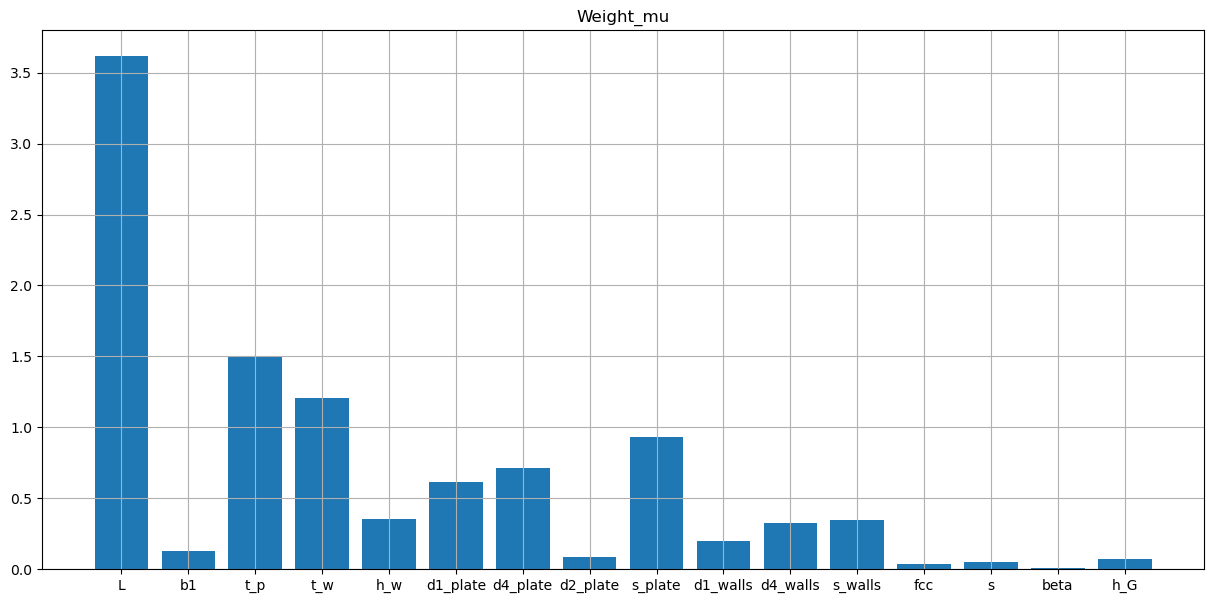

In [338]:
plt.figure(figsize=(15,7))
plt.bar(x_names, abs(l['0.weight_mu'][0]))
plt.title("Weight_mu")
plt.grid(True)

## 2.5 Model evaluation - SHAP

### 2.5.0 Example code to unserstand

In [348]:
from keras.layers import (
    Dense,
    Dropout,
    Flatten,
    Input,
    concatenate,
)
from keras.layers import Embedding
from keras.models import Model
from sklearn.model_selection import train_test_split

import shap

# print the JS visualization code to the notebook
shap.initjs()

In [349]:
X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)

# normalize data (this is important for model convergence)
dtypes = list(zip(X.dtypes.index, map(str, X.dtypes)))
for k, dtype in dtypes:
    if dtype == "float32":
        X[k] -= X[k].mean()
        X[k] /= X[k].std()

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=7)

In [379]:
X

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,0.030670,7,1.134791,4,1,0,4,1,0.148438,-0.216627,-0.035427,39
1,0.837095,6,1.134791,2,4,4,4,1,-0.145906,-0.216627,-2.222028,39
2,-0.042641,4,-0.420079,0,6,0,4,1,-0.145906,-0.216627,-0.035427,39
3,1.057029,4,-1.197514,2,6,4,2,1,-0.145906,-0.216627,-0.035427,39
4,-0.775755,4,1.134791,2,10,5,2,0,-0.145906,-0.216627,-0.035427,5
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,-0.849066,4,0.746074,2,13,5,4,0,-0.145906,-0.216627,-0.197398,39
32557,0.103981,4,-0.420079,2,7,4,4,1,-0.145906,-0.216627,-0.035427,39
32558,1.423586,4,-0.420079,6,1,1,4,0,-0.145906,-0.216627,-0.035427,39
32559,-1.215623,4,-0.420079,4,1,3,4,1,-0.145906,-0.216627,-1.655132,39


In [350]:
# build model
input_els = []
encoded_els = []
for k, dtype in dtypes:
    input_els.append(Input(shape=(1,)))
    if dtype == "int8":
        e = Flatten()(Embedding(X_train[k].max() + 1, 1)(input_els[-1]))
    else:
        e = input_els[-1]
    encoded_els.append(e)
encoded_els = concatenate(encoded_els)
layer1 = Dropout(0.5)(Dense(100, activation="relu")(encoded_els))
out = Dense(1)(layer1)

# train model
regression = Model(inputs=input_els, outputs=[out])
regression.compile(optimizer="adam", loss="binary_crossentropy")
regression.fit(
    [X_train[k].values for k, t in dtypes],
    y_train,
    epochs=50,
    batch_size=512,
    shuffle=True,
    validation_data=([X_valid[k].values for k, t in dtypes], y_valid),
)

Epoch 1/50


c:\Users\Antoine\anaconda3\envs\BNN\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_1', 'keras_tensor_4', 'keras_tensor_5', 'keras_tensor_8', 'keras_tensor_11', 'keras_tensor_12', 'keras_tensor_15', 'keras_tensor_18', 'keras_tensor_19', 'keras_tensor_20', 'keras_tensor_21']. Received: the structure of inputs=('*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*')
  warnings.warn(


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.9916 - val_loss: 0.4743
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5938 - val_loss: 0.5802
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5527 - val_loss: 0.5127
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3743 - val_loss: 0.5151
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3046 - val_loss: 0.4923
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2694 - val_loss: 0.4888
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1719 - val_loss: 0.6091
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2288 - val_loss: 0.4244
Epoch 9/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0289 - val_loss: 0.4046
Epoch 10/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9571 - val_loss: 0.3936
Epoch 11/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9346 - val_loss: 0.4057
Epoch 12/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8487 - val_loss: 0.5145


In [351]:
def f(X):
    return regression.predict([X[:, i] for i in range(X.shape[1])]).flatten()

In [353]:
explainer = shap.KernelExplainer(f, X.iloc[:50, :])

shap_values50 = explainer.shap_values(X.iloc[280:330, :], nsamples=500)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
782/782 ━━━━━━

In [354]:
shap.force_plot(explainer.expected_value, shap_values50, X_display.iloc[280:330, :])

### 2.5.1 Load model

In [5]:
# model_name='1001_1002_1003_no0_high_3_40_weighted_mse_100_0'
model_name='1001_1002_1003_no0_detail_6_40_weighted_mse_500_0'  # define manually
model = torch.load('trainedModels/high_level/'+model_name+'.pth')

model.eval() # sets the model to evaluation mode, which affects layers like dropout and batch normalization that behave differently during training and inference.
model

C:\Users\Antoine\AppData\Local\Temp\ipykernel_26544\1919186904.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('trainedModels/high_level/'+model_name+

Sequential(
  (0): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=16, out_features=20, bias=True)
  (1): ReLU()
  (2): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=20, out_features=20, bias=True)
  (3): ReLU()
  (4): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=20, out_features=20, bias=True)
  (5): ReLU()
  (6): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=20, out_features=20, bias=True)
  (7): ReLU()
  (8): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=20, out_features=20, bias=True)
  (9): ReLU()
  (10): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=20, out_features=1, bias=True)
  (11): ReLU()
)

### 2.5.2 Feature importance

In [6]:
import shap
shap.initjs()

In [7]:
from plotting import plot_true_vs_pred, single_para_strudy_perf
from MLmodel import bnn_predict_with_uncertainty, calculate_rmse, filter_values_within_range, calculate_mape, calculate_custom_loss, evaluate_model_performance

In [8]:
# Define number of predictions
n_predictions = 1000

def f(X_df):
    x_val_scaled_tensor=torch.tensor(X_df, dtype=torch.float32)
    y_val_mean_pred_np, y_val_std_pred_np, y_val_pred_n_times = bnn_predict_with_uncertainty(model, x_val_scaled_tensor, n=n_predictions,log_transform_back=False)
    return y_val_mean_pred_np.flatten()

In [9]:
explainer = shap.KernelExplainer(f, x_val_scaled_df.iloc[:50, :])

In [10]:
shap_values50 = explainer.shap_values(x_val_scaled_df.iloc[280:330, :], nsamples=500)

  0%|          | 0/50 [00:00<?, ?it/s]

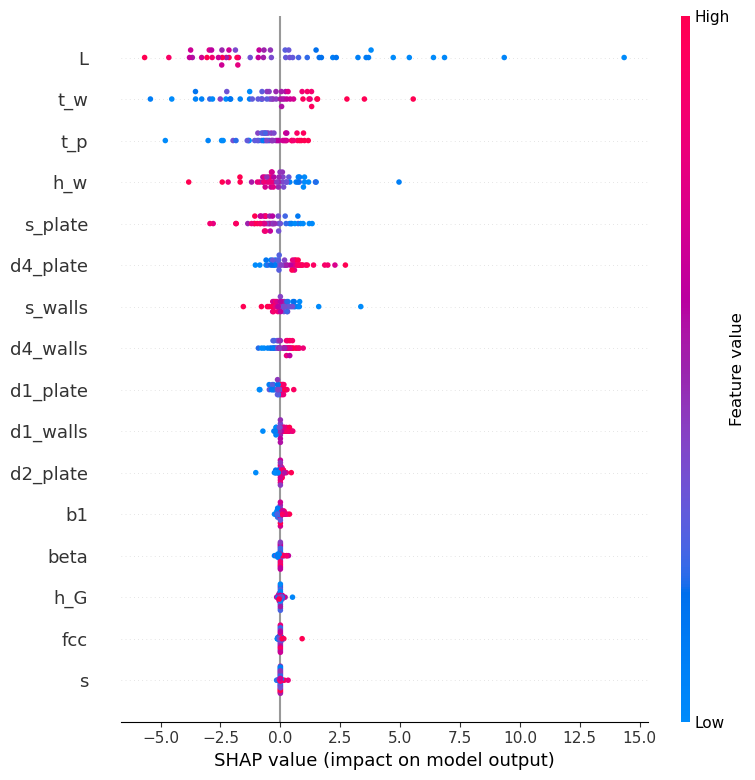

In [11]:
shap.summary_plot(shap_values50, x_val_df.iloc[280:330, :])

In [12]:
shap.force_plot(explainer.expected_value, shap_values50, x_val_df.iloc[280:330, :])